In [101]:
# !/usr/bin/env python

# [Future imports]
# "print" function compatibility between Python 2.x and 3.x
from __future__ import print_function
# Use Python 3.x "/" for division in Pyhton 2.x
from __future__ import division

# General Python
import sys
import os
sys.path.append('./')
# Data structures
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
dpi = 200
mpl.rc("savefig", dpi=dpi)
%matplotlib inline
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
from scipy import stats
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import seaborn as sns
import math
import re

from lmfit import minimize, Parameters, report_fit
from matplotlib.colors import LogNorm

#additional imports
import pandas as pd
from Bio import SeqIO, SeqRecord,Seq
import mkl_random
import random

import os
import subprocess
from Bio import Entrez, SeqIO
from copy import deepcopy
from pathlib import Path

import datetime
import time
import json
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

import seaborn as sb

import statistics

In [102]:
#list files containg depth stats for both spap orf and purexpress whole plasmid 
#output of samtools depth -a a- script
dirName_1to13_purexp_cov = '/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/spap_egfp_alignment_stats/20201222_SU011_MJA_1-13_trimmed_merged_mapped_reads_with_R1_R2_depth'
dirName_14_purexp_cov = '/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/spap_egfp_alignment_stats/20201219_SU012_MJA_14_trimmed_merged_mapped_reads_with_R1_R2_depth'

#generate list of files in directory
file_1to13_purexp = os.listdir(dirName_1to13_purexp_cov)
file_14_purexp = os.listdir(dirName_14_purexp_cov)


NOTES REGARDING DEPTH FILES
------------------------------------------
key positions in coverage file (computed for entire purexpress plasmid, but only expect coverage between
primers for SpAP-eGFP amplicon)

16-44=forward primer
88-2457=SpAP-eGFP ORF
2502-2525=reverse primer
Specify a +10 bp expanded segment for calculating coverage statistics (since very ends will likely suffer from 
poorer coverage, and are outside ORF anyway, do not want to include in coverage summary)
78-2467=expanded enzyme region


----
5/31/21
revise:
62-2448

## Parse output files from samtools depth and calculate coverage statistics for each barcode

In [141]:
#use this cell to parse samtools depth data file line by line and create a nested
#dictionary containing position/coverage for each library

#specify directory and file name to use in this cell (stored above)
dirName=dirName_1to13_purexp_cov
files=file_1to13_purexp
plot_out_dir='/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/depth_results/plots'


#create dict to store coverage data
cov_dict = {}


#define start and end positions within full aligned genome
#here use "expanded enzyme region from bases 78-2467"
genome_start_pos=62
genome_end_pos=2448

#create dataframe to store coverage stats for this directory and genome
coverage_df=pd.DataFrame()

#create lists to store coverage stats
sample_name = []
i7_barcode=[]
i5_barcode=[]
median_coverage_list=[] #median coverage for BC across genome of interest 
average_coverage_list=[] #average coverage for BC across genome of interest
frac_pos_0_list=[] #frac of positions with 0 coverage
frac_pos_1plus_list=[] #frac of positions with >=1 coverage
frac_pos_10plus_list=[] #frac of positions with >=10 coverage
frac_pos_50plus_list=[] #frac of positions with >=50 coverage
frac_pos_100plus_list=[] #frac of positions with >=100 coverage
frac_pos_1000plus_list=[]#frac of positions with >=1000 coverage




#made figure to add plots to (cleared after each loop)
plt.ioff()
fig = plt.figure(figsize=(10,4))

for a in files:
    sample_dict={}
    pos_list=[]
    cov_list=[]
    
    #get file name without extension
    name=a.split('.')
    
    #store sample name in file_name list
    sample_name.append(name[0])
   
    #pull out i7+i5 and store to lists
    i7=(name[0].split('-'))[3]
    i7_barcode.append(int(i7))
   
    i5=((name[0].split('-'))[7]).split('_')[0]
    i5_barcode.append(i5)
    
    #open file
    f = open(dirName + '/'+a,'r')
    
    #read in line by line
    for line in f:
        tempL = line.split('\t')
        
        #store position, add to position list
        position = tempL[1]
        pos_list.append(position)
        
        #store coverage, add to coverage list
        coverage = int(tempL[2])
        cov_list.append(coverage)
        
        
    #create lists of position and coverage that only include segment of genome specified above
    pos_list_select=pos_list[genome_start_pos-1:genome_end_pos]
    
    cov_list_select=cov_list[genome_start_pos-1:genome_end_pos]
   
    if len(cov_list_select) != 0:
        #median coverage for BC across genome of interest
        median_coverage=statistics.median(cov_list_select)  
        median_coverage_list.append(median_coverage)

        #average coverage for BC across genome of interest
        average_coverage=int(round(sum(cov_list_select)/len(cov_list_select))) 
        average_coverage_list.append(average_coverage)

        #frac of positions with 0 coverage
        count_0 = len([i for i in cov_list_select if i == 0])
        frac_pos_0=round((count_0/len(cov_list_select)),2) 
        frac_pos_0_list.append(frac_pos_0)
        
        #frac of positions with >= 1 coverage
        count_1plus = len([i for i in cov_list_select if i >= 1])
        frac_pos_1plus =round((count_1plus/len(cov_list_select)),2) 
        frac_pos_1plus_list.append(frac_pos_1plus)

        #frac of positions with >= 10 coverage
        count_10plus = len([i for i in cov_list_select if i >= 10])
        frac_pos_10plus =round((count_10plus/len(cov_list_select)),2) 
        frac_pos_10plus_list.append(frac_pos_10plus)
        
        
        #frac of positions with >= 50 coverage
        count_50plus = len([i for i in cov_list_select if i >= 50])
        frac_pos_50plus =round((count_50plus/len(cov_list_select)),2) 
        frac_pos_50plus_list.append(frac_pos_50plus)
        
        #frac of positions with >= 100 coverage
        count_100plus = len([i for i in cov_list_select if i >= 100])
        frac_pos_100plus =round((count_100plus/len(cov_list_select)),2) 
        frac_pos_100plus_list.append(frac_pos_100plus)
        
        #frac of positions with >= 1000 coverage
        count_1000plus = len([i for i in cov_list_select if i >= 1000])
        frac_pos_1000plus =round((count_1000plus/len(cov_list_select)),2) 
        frac_pos_1000plus_list.append(frac_pos_1000plus)
        
    #if coverage file is empty (not sure it doesn't show 0 as expected? must do with bam files?)
    #append None entries to entries for that barcode instead
    else:
        median_coverage_list.append(None)
        average_coverage_list.append(None)
        frac_pos_0_list.append(None)
        frac_pos_1plus_list.append(None)
        frac_pos_10plus_list.append(None)
        frac_pos_50plus_list.append(None)
        frac_pos_100plus_list.append(None)
        frac_pos_1000plus_list.append(None)
    
    
#     #output a bar graph of coverage across specified genome
#     ax = fig.add_subplot(111)
#     ax.bar(pos_list,cov_list,align='edge', width=1.0, color='gray', alpha=0.5)
#     plt.xticks(np.arange(-1, 5000, 250),fontsize=10)
#     plt.xlim(50,2500)
#     ax.set_xlabel('base position (SpAP-eGFP ORF = 62-2448)', fontsize=12)
#     ax.set_ylabel('read\ndepth', fontsize=12, rotation=0)
#     ax.yaxis.set_label_coords(-0.08,0.5)
#     plt.title(str(name[0]), fontsize=12)
#     plt.tight_layout()
    
#     #edit output dir here
#     plt.savefig(plot_out_dir+str(name[0]) + '.pdf')
    
#     #use the following command to suppress output and save time for this loop
#     plt.clf()
# #     plt.close()

##add coverage stats to dataframe and export csv
# coverage_df['Sample_full_name'] = sample_name
# coverage_df['i5'] = i5_barcode

coverage_df['i7'] = i7_barcode #only need i7 to merge with previous dataframes
coverage_df['average_coverage'] = average_coverage_list
coverage_df['median_coverage'] = median_coverage_list
coverage_df['frac_pos_cov=0'] = frac_pos_0_list
coverage_df['frac_pos_cov>=1'] = frac_pos_1plus_list
coverage_df['frac_pos_cov>=10'] = frac_pos_10plus_list
coverage_df['frac_pos_cov>=50'] = frac_pos_50plus_list
coverage_df['frac_pos_cov>=100'] = frac_pos_100plus_list
coverage_df['frac_pos_cov>=1000'] = frac_pos_1000plus_list

<Figure size 720x288 with 0 Axes>

In [142]:
coverage_df.to_csv('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/depth_results/coverage_stats/20210602_plates_1-13_depth_stats.csv')

## Comparison of paired only vs. all alignments (Plates 1-13 only)

In [20]:

# coverage_paired_DF=coverage_df.copy()
coverage_paired_DF.head() #this is from df containing paired read workup only

,i7,average_coverage,median_coverage,frac_pos_cov=0,frac_pos_cov>=1,frac_pos_cov>=10,frac_pos_cov>=50,frac_pos_cov>=100
0,1081,134.0,82.0,0.0,1.0,1.0,0.87,0.30
1,5978,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5902,344.0,248.0,0.0,1.0,1.0,1.00,0.99
3,1834,416.0,329.0,0.0,1.0,1.0,1.00,1.00
4,2008,507.0,497.0,0.0,1.0,1.0,1.00,1.00


<Figure size 432x288 with 0 Axes>

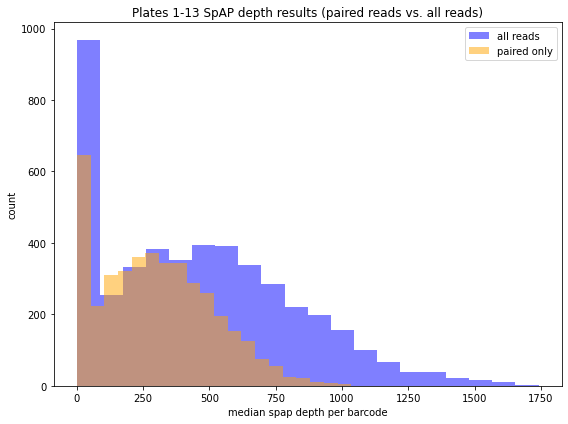

In [27]:
paired_SPAP = coverage_paired_DF['median_coverage'].tolist()
all_SPAP = coverage_df['median_coverage'].tolist()
#make histogram
plt.clf()
plt.figure(figsize=(8,6))
plt.hist(all_SPAP, bins=20, alpha=0.5, color='blue', label="all reads")
plt.hist(paired_SPAP, bins=20, alpha=0.5, color='orange', label="paired only")
plt.legend(loc='upper right')
plt.xlabel("median spap depth per barcode")
plt.ylabel("count")
plt.title("Plates 1-13 SpAP depth results (paired reads vs. all reads)")
plt.tight_layout()
plt.savefig('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/depth_results/plots/20210601_plates_1-13_spap_depth_paired_vs_unpaired_hist.png')
plt.savefig('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/depth_results/plots/20210601_plates_1-13_spap_depth_paired_vs_unpaired_hist.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

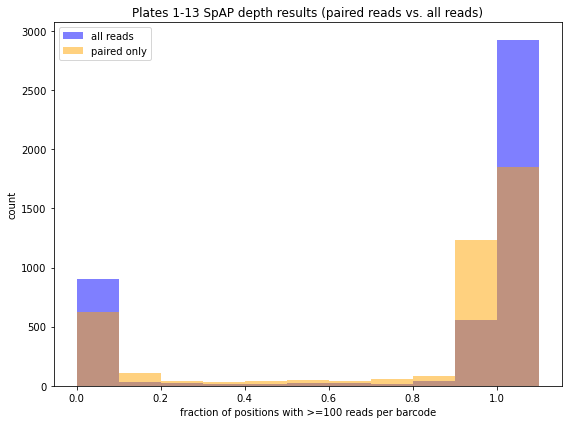

In [30]:
paired_SPAP = coverage_paired_DF['frac_pos_cov>=100'].tolist()
all_SPAP = coverage_df['frac_pos_cov>=100'].tolist()
#make histogram
plt.clf()
plt.figure(figsize=(8,6))
plt.hist(all_SPAP, bins=[0,.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0, 1.1], alpha=0.5, color='blue', label="all reads")
plt.hist(paired_SPAP, bins=[0,.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1], alpha=0.5, color='orange', label="paired only")
plt.legend(loc='upper left')
plt.xlabel("fraction of positions with >=100 reads per barcode")
plt.ylabel("count")
plt.title("Plates 1-13 SpAP depth results (paired reads vs. all reads)")
plt.tight_layout()
plt.savefig('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/depth_results/plots/20210601_plates_1-13_spap_frac100+_paired_vs_unpaired_hist.png')
plt.savefig('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/depth_results/plots/20210601_plates_1-13_spap_frac100+_paired_vs_unpaired_hist.pdf')
plt.show()

In [144]:
#use this cell to parse samtools depth data file line by line and create a nested
#dictionary containing position/coverage for each library

#specify directory and file name to use in this cell (stored above)
dirName=dirName_14_purexp_cov
files=file_14_purexp
plot_out_dir='/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/depth_results/plots'


#create dict to store coverage data
cov_dict = {}


#define start and end positions within full aligned genome
#here use "expanded enzyme region from bases 78-2467"
genome_start_pos=78
genome_end_pos=2467

#create dataframe to store coverage stats for this directory and genome
coverage_df=pd.DataFrame()

#create lists to store coverage stats
sample_name = []
i7_barcode=[]
i5_barcode=[]
median_coverage_list=[] #median coverage for BC across genome of interest 
average_coverage_list=[] #average coverage for BC across genome of interest
frac_pos_0_list=[] #frac of positions with 0 coverage
frac_pos_1plus_list=[] #frac of positions with >=1 coverage
frac_pos_10plus_list=[] #frac of positions with >=10 coverage
frac_pos_50plus_list=[] #frac of positions with >=50 coverage
frac_pos_100plus_list=[] #frac of positions with >=100 coverage
frac_pos_1000plus_list=[]#frac of positions with >=1000 coverage


#made figure to add plots to (cleared after each loop)
plt.ioff()
fig = plt.figure(figsize=(10,4))

for a in files:
    sample_dict={}
    pos_list=[]
    cov_list=[]
    
    #get file name without extension
    name=a.split('.')
    
    #store sample name in file_name list
    sample_name.append(name[0])
   
    #pull out i7+i5 and store to lists
    i7=(name[0].split('-'))[3]
    i7_barcode.append(int(i7))
   
    i5=((name[0].split('-'))[7]).split('_')[0]
    i5_barcode.append(i5)
    
    #open file
    f = open(dirName + '/'+a,'r')
    
    #read in line by line
    for line in f:
        tempL = line.split('\t')
        
        #store position, add to position list
        position = tempL[1]
        pos_list.append(position)
        
        #store coverage, add to coverage list
        coverage = int(tempL[2])
        cov_list.append(coverage)
        
        
    #create lists of position and coverage that only include segment of genome specified above
    pos_list_select=pos_list[genome_start_pos-1:genome_end_pos]
    
    cov_list_select=cov_list[genome_start_pos-1:genome_end_pos]
   
    if len(cov_list_select) != 0:
        #median coverage for BC across genome of interest
        median_coverage=statistics.median(cov_list_select)  
        median_coverage_list.append(median_coverage)

        #average coverage for BC across genome of interest
        average_coverage=int(round(sum(cov_list_select)/len(cov_list_select))) 
        average_coverage_list.append(average_coverage)

        #frac of positions with 0 coverage
        count_0 = len([i for i in cov_list_select if i == 0])
        frac_pos_0=round((count_0/len(cov_list_select)),2) 
        frac_pos_0_list.append(frac_pos_0)
        
        #frac of positions with >= 1 coverage
        count_1plus = len([i for i in cov_list_select if i >= 1])
        frac_pos_1plus =round((count_1plus/len(cov_list_select)),2) 
        frac_pos_1plus_list.append(frac_pos_1plus)

        #frac of positions with >= 10 coverage
        count_10plus = len([i for i in cov_list_select if i >= 10])
        frac_pos_10plus =round((count_10plus/len(cov_list_select)),2) 
        frac_pos_10plus_list.append(frac_pos_10plus)
        
        
        #frac of positions with >= 50 coverage
        count_50plus = len([i for i in cov_list_select if i >= 50])
        frac_pos_50plus =round((count_50plus/len(cov_list_select)),2) 
        frac_pos_50plus_list.append(frac_pos_50plus)
        
        #frac of positions with >= 100 coverage
        count_100plus = len([i for i in cov_list_select if i >= 100])
        frac_pos_100plus =round((count_100plus/len(cov_list_select)),2) 
        frac_pos_100plus_list.append(frac_pos_100plus)
        
        #frac of positions with >= 1000 coverage
        count_1000plus = len([i for i in cov_list_select if i >= 1000])
        frac_pos_1000plus =round((count_1000plus/len(cov_list_select)),2) 
        frac_pos_1000plus_list.append(frac_pos_1000plus)
        
    #if coverage file is empty (not sure it doesn't show 0 as expected? must do with bam files?)
    #append None entries to entries for that barcode instead
    else:
        median_coverage_list.append(None)
        average_coverage_list.append(None)
        frac_pos_0_list.append(None)
        frac_pos_1plus_list.append(None)
        frac_pos_10plus_list.append(None)
        frac_pos_50plus_list.append(None)
        frac_pos_100plus_list.append(None)
        frac_pos_1000plus_list.append(None)
    
    
#     #output a bar graph of coverage across specified genome
#     ax = fig.add_subplot(111)
#     ax.bar(pos_list,cov_list,align='edge', width=1.0, color='gray', alpha=0.5)
#     plt.xticks(np.arange(-1, 5000, 250),fontsize=10)
#     plt.xlim(50,2500)
#     ax.set_xlabel('base position (SpAP-eGFP ORF = 78-2467)', fontsize=12)
#     ax.set_ylabel('read\ndepth', fontsize=12, rotation=0)
#     ax.yaxis.set_label_coords(-0.08,0.5)
#     plt.title(str(name[0]), fontsize=12)
#     plt.tight_layout()
    
#     #edit output dir here
#     plt.savefig(plot_out_dir+str(name[0]) + '.pdf')
    
#     #use the following command to suppress output and save time for this loop
#     #essential or memory will fill
#     plt.clf()
#     plt.close()

##add coverage stats to dataframe and export csv
# coverage_df['Sample_full_name'] = sample_name
# coverage_df['i5'] = i5_barcode

coverage_df['i7'] = i7_barcode #only need i7 to merge with previous dataframes
coverage_df['average_coverage'] = average_coverage_list
coverage_df['median_coverage'] = median_coverage_list
coverage_df['frac_pos_cov=0'] = frac_pos_0_list
coverage_df['frac_pos_cov>=1'] = frac_pos_1plus_list
coverage_df['frac_pos_cov>=10'] = frac_pos_10plus_list
coverage_df['frac_pos_cov>=50'] = frac_pos_50plus_list
coverage_df['frac_pos_cov>=100'] = frac_pos_100plus_list
coverage_df['frac_pos_cov>=1000'] = frac_pos_1000plus_list

<Figure size 720x288 with 0 Axes>

In [145]:
coverage_df.to_csv('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/depth_results/coverage_stats/20210602_plates_14_depth_stats.csv')

coverage_df.copy()

,i7,average_coverage,median_coverage,frac_pos_cov=0,frac_pos_cov>=1,frac_pos_cov>=10,frac_pos_cov>=50,frac_pos_cov>=100,frac_pos_cov>=1000
0,5841,1105.0,1076.0,0.0,1.0,1.00,1.00,1.00,0.66
1,5991,1835.0,1765.0,0.0,1.0,1.00,1.00,1.00,1.00
2,6095,1353.0,1240.0,0.0,1.0,1.00,1.00,1.00,0.98
3,5968,492.0,436.0,0.0,1.0,1.00,1.00,1.00,0.00
4,6092,419.0,404.0,0.0,1.0,1.00,1.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...
349,5918,1518.0,1496.0,0.0,1.0,0.99,0.99,0.99,0.98
350,5800,634.0,618.0,0.0,1.0,1.00,1.00,1.00,0.04
351,6077,1097.0,1062.0,0.0,1.0,1.00,1.00,1.00,0.62
352,6062,1060.0,1026.0,0.0,1.0,1.00,1.00,1.00,0.55


In [146]:
#import dataframes from notebook I (READ STATS/PLATE/WELL INFO)
##plates 1-13
plates1to13_df_wells=pd.read_csv('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/read_stats/20210531_plates_1-13_read_stats_allgenomes_plate_well.csv')
plates1to13_df_wells.drop(columns=['Unnamed: 0'], inplace=True)

#plates 14
plate14_df_wells=pd.read_csv('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/read_stats/20210531_plates_14_read_stats_allgenomes_plate_well.csv')
plate14_df_wells.drop(columns=['Unnamed: 0'], inplace=True)

##merge and export
##plates1-13
# plates1to13_df_merged = pd.merge(left=plates1to13_df_wells, right=coverage_df, left_on='i7', right_on='i7')
# plates1to13_df_merged.to_csv('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/depth_results/20210602_plates_1-13_read_stats_allgenomes_cov_stats.csv')


# # ##plate 14
plate14_df_merged = pd.merge(left=plate14_df_wells, right=coverage_df, left_on='i7', right_on='i7')
plate14_df_merged.to_csv('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/depth_results/20210602_plate_14_read_stats_allgenomes_cov_stats.csv')

#all plates
merged_df_all=pd.concat([plates1to13_df_merged, plate14_df_merged])
merged_df_all.to_csv('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/depth_results/20210602_plates_1-14_read_stats_allgenomes_cov_stats.csv')

## Split into individual plates, and export csvs

In [147]:
#import merged dataframe if necessary
merged_df_all=pd.read_csv('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/depth_results/20210602_plates_1-14_read_stats_allgenomes_cov_stats.csv')

df_for_split=merged_df_all.copy()

#specify list of individual plates by plate number
plate_list=range(1,15)

#create empty lists to store dataframes by name
summary_df_list=[]
summary_df_250_list=[]

#export plates 1-13
for i in plate_list:
    temp_df=merged_df_all.loc[df_for_split['plate'] == i]
    print (str(len(temp_df)) + " plate "+str(i)+" samples")
    temp_df.to_csv ('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/depth_results/per_plate/20210602_plate_'+str(i)+'_read_stats_allgenomes_cov_stats.csv')
    temp_df.name="plate"+str(i)+"df"
    summary_df_list.append(temp_df)
       
#     #also export culled dataframes (>= 250 reads)
#     tempdf_250=temp_df.loc[temp_df['Total_reads'] >= 250]
#     print (str(len(tempdf_250)) + " plate "+str(i)+" samples >= 250")
#     tempdf_250.to_csv ('/media/mason/af107e63-c4f6-4771-8333-2564012a8270/Appel_MutSequencing/coverage_stats/coverage_stats_split_plates_250_culled/20210101plate'+str(i)+'_read_stats_allgenomes_cov_stats_250.csv')
#     tempdf_250.name="plate"+str(i)+"df_250"
#     summary_df_250_list.append(tempdf_250)


369 plate 1 samples
372 plate 2 samples
344 plate 3 samples
383 plate 4 samples
356 plate 5 samples
382 plate 6 samples
377 plate 7 samples
380 plate 8 samples
359 plate 9 samples
384 plate 10 samples
378 plate 11 samples
253 plate 12 samples
309 plate 13 samples
354 plate 14 samples


In [148]:
merged_df_all

,Unnamed: 0,Sample_ID,Sample_full_name,i7,i5,Total_reads,Mapped_reads_spap,Mapped_reads_purexp,Mapped_reads_ecoli,Frac_spap_reads,...,plate,well,average_coverage,median_coverage,frac_pos_cov=0,frac_pos_cov>=1,frac_pos_cov>=10,frac_pos_cov>=50,frac_pos_cov>=100,frac_pos_cov>=1000
0,0,S1386,CZB-NXT-i7-02153-CZB-NXT-i5-01769_S1386_L001_s...,2153,1769,10997,10574,10768,11,0.96,...,11,233,929.0,885.0,0.00,1.00,1.00,1.00,1.00,0.15
1,1,S1884,CZB-NXT-i7-03803-CZB-NXT-i5-03419_S1884_L001_s...,3803,3419,5169,4746,4883,0,0.92,...,4,347,427.0,367.0,0.00,1.00,1.00,1.00,1.00,0.07
2,2,S2353,CZB-NXT-i7-04272-CZB-NXT-i5-03888_S2353_L001_s...,4272,3888,1175,907,958,59,0.77,...,6,48,44.0,43.0,0.04,0.96,0.96,0.27,0.01,0.00
3,3,S4104,CZB-NXT-i7-06791-CZB-NXT-i5-06407_S4104_L001_s...,6791,6407,9862,9535,9724,4,0.97,...,10,263,861.0,755.0,0.00,1.00,1.00,1.00,1.00,0.09
4,4,S2373,CZB-NXT-i7-04292-CZB-NXT-i5-03908_S2373_L001_s...,4292,3908,149,115,129,0,0.77,...,6,68,4.0,3.0,0.01,0.99,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,349,S93,CZB-NXT-i7-05852-CZB-NXT-i5-05468_S93_L001_spa...,5852,5468,13182,12773,12972,0,0.97,...,14,92,1036.0,971.0,0.00,1.00,1.00,1.00,1.00,0.40
4996,350,S161,CZB-NXT-i7-05920-CZB-NXT-i5-05536_S161_L001_sp...,5920,5536,27074,26275,26697,1,0.97,...,14,160,2042.0,1912.0,0.00,1.00,1.00,1.00,1.00,1.00
4997,351,S286,CZB-NXT-i7-06045-CZB-NXT-i5-05661_S286_L001_sp...,6045,5661,14358,13807,14062,5,0.96,...,14,285,991.0,985.0,0.00,1.00,1.00,1.00,1.00,0.42
4998,352,S293,CZB-NXT-i7-06052-CZB-NXT-i5-05668_S293_L001_sp...,6052,5668,6678,6429,6529,0,0.96,...,14,292,435.0,444.0,0.00,1.00,1.00,1.00,1.00,0.00


## Make coverage stat histograms for Figure 6

In [156]:
#set the value globally
plt.rcParams['axes.linewidth'] = 1 

#specify plate numbers in dataframe containing depth information
plateNums=np.arange(1,14)
##make lists to store depth stats
#number of plate
platesL=[]
#total number of samples in plate
totalBCsL=[]
#number of barcodes with >= 1 read at all positions
oneplusL=[]
#number of barcodes with >= 10 read at all positions
tenplusL=[]
#number of barcodes with >= 100 read at all positions
hundredplusL=[]
#number of barcodes with >= 1000 read at all positions
thousandplusL=[]
#number of barcodes with >= 1 read at all positions AND >= 10 reads at >=0.95 positions
finalThresholdL=[]

#first calculate stats for plates 1-13
platesL.append("all")
#total number of barcodes containing mapped SpAP reads
totalBCs=len(merged_df_all.loc[(merged_df_all['plate']!=14) & (merged_df_all['Mapped_reads_spap']>0)])
totalBCsL.append(totalBCs)
#>=1
oneplus=len(merged_df_all.loc[(merged_df_all['plate']!=14) & (merged_df_all['frac_pos_cov>=1']==1.00)])
oneplusL.append(oneplus)
#>=10
tenplus=len(merged_df_all.loc[(merged_df_all['plate']!=14) & (merged_df_all['frac_pos_cov>=10']==1.00)])
tenplusL.append(tenplus)
#>=100
hundredplus=len(merged_df_all.loc[(merged_df_all['plate']!=14) & (merged_df_all['frac_pos_cov>=100']==1.00)])
hundredplusL.append(hundredplus) 
#>=1000
thousandplus=len(merged_df_all.loc[(merged_df_all['plate']!=14) & (merged_df_all['frac_pos_cov>=1000']==1.00)])
thousandplusL.append(thousandplus)     
#number of barcodes with >= 1 read at all positions AND >= 10 reads at >=0.95 positions
finalThreshold=len(merged_df_all.loc[(merged_df_all['plate']!=14)&(merged_df_all['frac_pos_cov>=1'] == 1.00) & (merged_df_all['frac_pos_cov>=10'] > 0.94)])
finalThresholdL.append(finalThreshold) 




#for each plate, use summary DF to calculate depth stats and add to lists
for num in plateNums:
    plateNum=num
    platesL.append(plateNum)
    #total number of barcodes containing mapped SpAP reads
    totalBCs=len(merged_df_all.loc[(merged_df_all['plate']==plateNum) & (merged_df_all['Mapped_reads_spap']>0)])
    totalBCsL.append(totalBCs)
    #>=1
    oneplus=len(merged_df_all.loc[(merged_df_all['plate']==plateNum) & (merged_df_all['frac_pos_cov>=1']==1.00)])
    oneplusL.append(oneplus)
    #>=10
    tenplus=len(merged_df_all.loc[(merged_df_all['plate']==plateNum) & (merged_df_all['frac_pos_cov>=10']==1.00)])
    tenplusL.append(tenplus)
    #>=100
    hundredplus=len(merged_df_all.loc[(merged_df_all['plate']==plateNum) & (merged_df_all['frac_pos_cov>=100']==1.00)])
    hundredplusL.append(hundredplus) 
    
    #>=1000
    thousandplus=len(merged_df_all.loc[(merged_df_all['plate']==plateNum) & (merged_df_all['frac_pos_cov>=1000']==1.00)])
    thousandplusL.append(thousandplus) 
    
    #number of barcodes with >= 1 read at all positions AND >= 10 reads at >=0.95 positions
    finalThreshold=len(merged_df_all.loc[(merged_df_all['plate']==plateNum)&(merged_df_all['frac_pos_cov>=1'] == 1.00) & (merged_df_all['frac_pos_cov>=10'] > 0.94)])
    finalThresholdL.append(finalThreshold) 
    
##save these lists to a new DF and export
depthStatDF=pd.DataFrame()
depthStatDF['plate']=platesL
depthStatDF['total barcodes with SpAP reads']=totalBCsL
depthStatDF['>= 1 all spap positions']=oneplusL
depthStatDF['>= 10 all spap positions']=tenplusL
depthStatDF['>= 100 all spap positions']=hundredplusL
depthStatDF['>= 1000 all spap positions']=thousandplusL
depthStatDF['meeting final threshold']=finalThresholdL

depthStatDF.to_csv('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/depth_results/20210602_plates_1-13_SpAP-eGFP_depth_threshold_summary.csv', index=False)

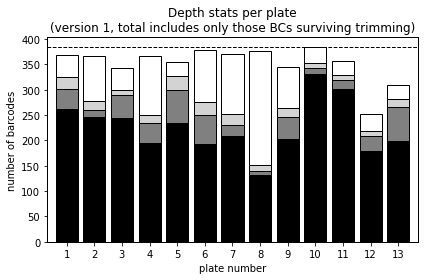

In [119]:
##Construct stacked bar chart -- version 1, only show total using barcodes that had reads after trimming 
##(this sums to different quantities per plate)
L1=hundredplusL #hundred plus
L2=np.subtract(tenplusL, hundredplusL) #number in 10 plus but not 100 plus
L3=np.subtract(oneplusL, tenplusL) #number in 1 plus but not 10 plus
L4=np.subtract(totalBCsL, oneplusL) #number in total but not 1 plus

p1 = plt.bar(plateNums, L1, width=0.8, color='black', edgecolor='k')
p2 = plt.bar(plateNums, L2, bottom=L1, width=0.8, color='gray', edgecolor='k')
p3 = plt.bar(plateNums, L3,bottom=np.add(L1, L2),width=0.8, color='lightgray', edgecolor='k')
p4 = plt.bar(plateNums, L4,bottom=np.add(np.add(L1, L2), L3),width=0.8, color='white', edgecolor='k')

#add features
plt.xlabel('plate number')
plt.ylabel('number of barcodes')
plt.xlim(0.3depthStatDF,13.7)
plt.xticks(np.arange(1,14))
plt.title('Depth stats per plate\n(version 1, total includes only those BCs surviving trimming)')
plt.tight_layout()
plt.axhline(384, linestyle='dashed', linewidth=1.0, color='k')

#save fig
plt.savefig('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/depth_results/plots/20210602_plates_1-13_depth_stacked_bar_v3.png')
plt.savefig('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/depth_results/plots/20210602_plates_1-13_depth_stacked_bar_v3.pdf')
# plt.clf()
# plt.close()


In [152]:
depthStatDF

,plate,total barcodes with SpAP reads,>= 1 all spap positions,>= 10 all spap positions,>= 100 all spap positions,>= 1000 all spap positions,meeting final threshold
0,1,369,325,301,262,0,318
1,2,367,277,260,246,0,274
2,3,342,300,289,244,0,298
3,4,367,251,234,194,0,247
4,5,355,327,299,234,0,315
5,6,378,276,250,192,0,264
6,7,371,252,230,209,0,241
7,8,376,151,139,131,0,146
8,9,345,263,247,202,0,260
9,10,384,352,342,331,0,352


In [131]:
depthStatDF['total barcodes with SpAP reads'].sum()

4571

In [132]:
depthStatDF

,plate,total barcodes with SpAP reads,>= 1 all spap positions,>= 10 all spap positions,>= 100 all spap positions
0,1,369,325,301,262
1,2,367,277,260,246
2,3,342,300,289,244
3,4,367,251,234,194
4,5,355,327,299,234
5,6,378,276,250,192
6,7,371,252,230,209
7,8,376,151,139,131
8,9,345,263,247,202
9,10,384,352,342,331
